<div align="center"><h1>Gender Classification with CNN</h1></div>

<div class="alert alert-info">
    Importing necessary libraries

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras import datasets, layers, models, saving
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-12-18 17:04:54.523915: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-18 17:04:54.531503: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-18 17:04:54.604413: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-18 17:04:54.669032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734537894.743695   14205 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734537894.76

## Data loading from source

##### Dataset 1 : Gender classification

In [2]:
IMG_SIZE = 103 #The desired size of the image input
size = (IMG_SIZE,IMG_SIZE)

path_dataset = "./dataset/"
train_val_directories = ["Training","Validation"]
female_male_directories = ["female", "male"]

image_list = []
labels_order = []
counts_list = []
counter = 0
for dataset in train_val_directories:
    for gender_directory in female_male_directories:
        labels_order.append(gender_directory)
        img_name_list = os.listdir(path_dataset+dataset+"/"+gender_directory)
        for img_name in img_name_list:
            input_image = cv2.imread(path_dataset+dataset+"/"+gender_directory+"/"+img_name)
            input_image = cv2.resize(input_image, size)
            image_list.append(input_image)
            counter += 1
        counts_list.append(counter)
print(f"{counts_list[-1]} images loaded from Gender Classification dataset")

58658 images loaded from Gender Classification dataset


#### Dataset1 labelling

In [3]:
# female : 0
# male : 1
labels_dataset1 = np.ones(len(image_list))
current_index = 0
for i,label in zip(counts_list,labels_order):
    if label == "female":
        labels_dataset1[current_index:i] = 0
    current_index = i

##### Dataset 2 : UTK Faces

In [4]:
def load_from_utkfaces(path):
    img_name_list = os.listdir(path)
    ages_utkfaces = []
    image_list = []
    labels_utkfaces = []
    for img_name in img_name_list:
        input_image = cv2.imread(path+"/"+img_name)
        input_image = cv2.resize(input_image, size)
        image_list.append(input_image)
        img_name = img_name.split("_")
        labels_utkfaces.append(abs(int(img_name[1])-1))
        ages_utkfaces.append(int(img_name[0]))
    return image_list, labels_utkfaces, ages_utkfaces

image_list_utk, labels_utk, ages_utk = load_from_utkfaces("./dataset/UTKFace")
print(f"{len(image_list_utk)} images loaded from UTKFace dataset")

23707 images loaded from UTKFace dataset


## Combining both datasets

In [5]:
utk_img_number = 20000
img_data = np.array(image_list+image_list_utk[:utk_img_number])
labels = np.concatenate((labels_dataset1,np.array(labels_utk[:utk_img_number])))

## Data augmentation

In [8]:
def underexposed_and_blur(img, n):
    # si la somme du nombre de pixels de niveaux de gris <= 150 est entre 7000 et 8400 ===> gamma = 3
    # si cette somme est suppérieur à 8400 ===> gamma = 1
    # sinon gamma = 4
    #gamma_table=[np.power(x/255.0,gamma)*255.0 for x in range(256)]
    #gamma_table=np.round(np.array(gamma_table)).astype(np.uint8)
    for i in range(n):
        img = cv2.GaussianBlur(img, (5,5),1)
    return img

def data_augmentation_first_dataset(X,Y):
    compteur = 0

    seuil_min = 7000
    seuil_max = 8400
    
    gamma = 1
    
    initial_length = X.shape[0]

    new_images = []

    directory = "female"
    for i in range(initial_length):
        im = cv2.cvtColor(X[i],cv2.COLOR_BGR2GRAY)
        pixel_values, eff = np.unique(im, return_counts=True)
        somme = np.sum(eff[pixel_values<=150])
        if somme < seuil_min:
            gamma = 3
        elif somme < seuil_max:
            gamme = 2

        # Apply transformation to each image.
        new_img = underexposed_and_blur(X[i],gamma)
        if Y[i] == 1:
            directory = "male"
        else:
            directory = "female"
        
        cv2.imwrite(f"./dataset/Augmented_1/{directory}/image{i}.png",new_img)
        new_images.append(new_img)

    return new_images

def data_augmentation_utkfaces(X,Y,n):
    seuil_min = 3000
    seuil_max = 8400
    gamma = 0
    initial_length = len(X)
    new_images = []

    for i in range(initial_length):
        if (ages_utk[i]<10) or (ages_utk[i]>80):
            continue
        im = cv2.cvtColor(X[i],cv2.COLOR_BGR2GRAY)
        #pixel_values, eff = np.unique(im, return_counts=True)
        #somme = np.sum(eff[pixel_values<=150])
        #if somme < seuil_min:
        #    gamma = 3
        #elif somme < seuil_max:
        #    gamme = 2

        # Apply transformation to each image.
        new_img = underexposed_and_blur(X[i],n)
        
        cv2.imwrite(f"./dataset/Augmented_2/{ages_utk[i]}_{abs(Y[i]-1)}_{i}.png",new_img)
        new_images.append(new_img)

    return new_images

In [9]:
truc = data_augmentation_utkfaces(image_list_utk,labels_utk,10)

## Normalisation & Shuffle

In [6]:
img_data = img_data.astype(dtype="float32",copy=False)
img_data /= 255. #Normalization 

In [7]:
img_data, labels = shuffle(img_data,labels)
X = img_data
Y = labels

In [8]:
def afficher_images(images,labels,num):
    plt.figure(figsize=(num,num+2))
    k = 0
    for img in images[:num]:  
        plt.subplot(round(num/2),round(num/2),k+1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        if labels[k] == 1:
            plt.title("Homme")
        elif labels[k] == 0:
            plt.title("Femme")
        k += 1
    plt.show()

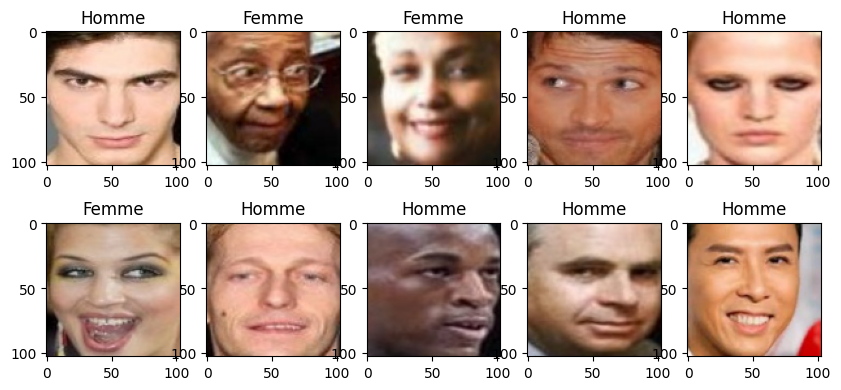

In [9]:
afficher_images(X,Y,10)

## CNN Model : Architecture

<div align = "center"><img src="./Convolution.png" alt="Convolutional neural network Architecture"/></div>

In [10]:
def create_model():
    model = models.Sequential()

    model.add(layers.Input((IMG_SIZE,IMG_SIZE,3)))
    
    model.add(layers.Conv2D(32,(3,3), activation="relu",padding="same"))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2D(64,(5,5), activation="relu", padding="same"))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2D(64,(3,3), activation="relu", padding="same"))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128,(5,5), activation="relu", padding="same"))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128,(3,3), activation="relu", padding="same"))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(200, activation="relu"))
    
    model.add(layers.Dense(2, activation="softmax"))
    return model

In [11]:
create_model().summary()

2024-12-18 17:05:53.485900: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 103, 103, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 51, 51, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 51, 51, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 51, 51, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │       230,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 672,602 (2.57 MB)

 Trainable params: 672,602 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

### Train & Test

In [14]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(img_data,labels, test_size = 0.20, shuffle=True, stratify=labels)
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain,Ytrain, test_size = 0.20, shuffle=True, stratify=Ytrain)

In [15]:
batch_size = 100
epochs = 10

model = create_model()
model.compile(optimizer="adam",
              loss= "sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(Xtrain,Ytrain,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(Xval,Yval))

Epoch 1/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 340s 742ms/step - accuracy: 0.7099 - loss: 0.5190 - val_accuracy: 0.9231 - val_loss: 0.1979
Epoch 2/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 336s 743ms/step - accuracy: 0.9232 - loss: 0.1950 - val_accuracy: 0.9364 - val_loss: 0.1691
Epoch 3/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 322s 711ms/step - accuracy: 0.9389 - loss: 0.1569 - val_accuracy: 0.9477 - val_loss: 0.1364
Epoch 4/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 301s 664ms/step - accuracy: 0.9424 - loss: 0.1492 - val_accuracy: 0.9480 - val_loss: 0.1343
Epoch 5/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 302s 667ms/step - accuracy: 0.9453 - loss: 0.1409 - val_accuracy: 0.9521 - val_loss: 0.1308
Epoch 6/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 414s 914ms/step - accuracy: 0.9507 - loss: 0.1288 - val_accuracy: 0.9513 - val_loss: 0.1267
Epoch 7/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 330s 729ms/step - accuracy: 0.9538 - loss: 0.1234 - val_accuracy: 0.9502 - val_loss: 0.1316
Epoch 8/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 302s 667ms/step - accuracy: 0.9555 -

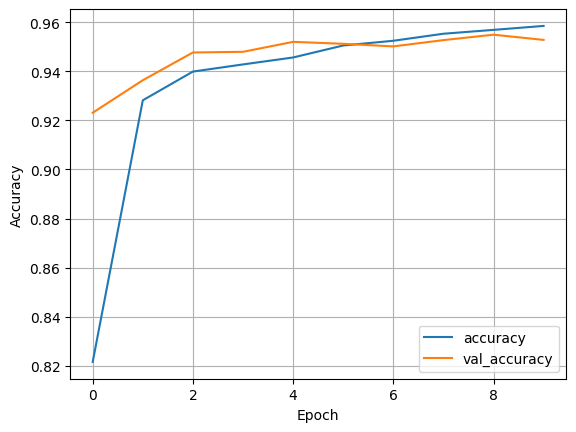

In [16]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

442/442 ━━━━━━━━━━━━━━━━━━━━ 32s 73ms/step
Confusion Matrix


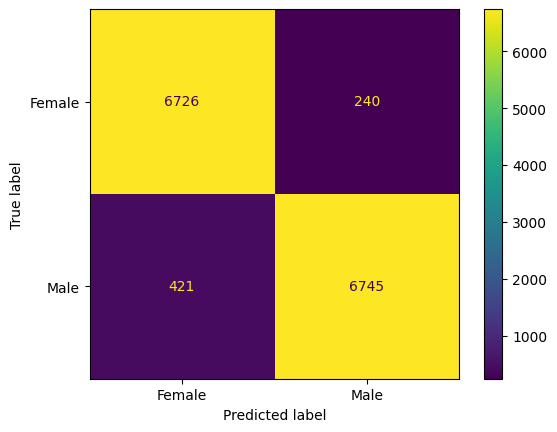

In [17]:
prediction = model.predict(Xtest)
Ypred = np.argmax(prediction, axis=1)
print('Confusion Matrix')

confusion_matrix = metrics.confusion_matrix(Ytest, Ypred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Female", "Male"])
cm_display.plot()
plt.show()

### K-Fold : Cross validation

Fold-1
Epoch 1/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 352s 744ms/step - accuracy: 0.6693 - loss: 0.5674
Epoch 2/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 356s 757ms/step - accuracy: 0.9396 - loss: 0.1645
Epoch 3/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 390s 830ms/step - accuracy: 0.9506 - loss: 0.1364
Epoch 4/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 388s 825ms/step - accuracy: 0.9560 - loss: 0.1216
Epoch 5/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 372s 791ms/step - accuracy: 0.9599 - loss: 0.1125
Epoch 6/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 367s 782ms/step - accuracy: 0.9610 - loss: 0.1080
Epoch 7/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 377s 803ms/step - accuracy: 0.9619 - loss: 0.1020
Epoch 8/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 545s 1s/step - accuracy: 0.9668 - loss: 0.0938
Epoch 9/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 348s 741ms/step - accuracy: 0.9656 - loss: 0.0945
Epoch 10/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 333s 709ms/step - accuracy: 0.9664 - loss: 0.0921
367/367 ━━━━━━━━━━━━━━━━━━━━ 29s 78ms/step - accuracy: 0.9630 - loss: 0.1003
Fold-2
Epoch 1/10


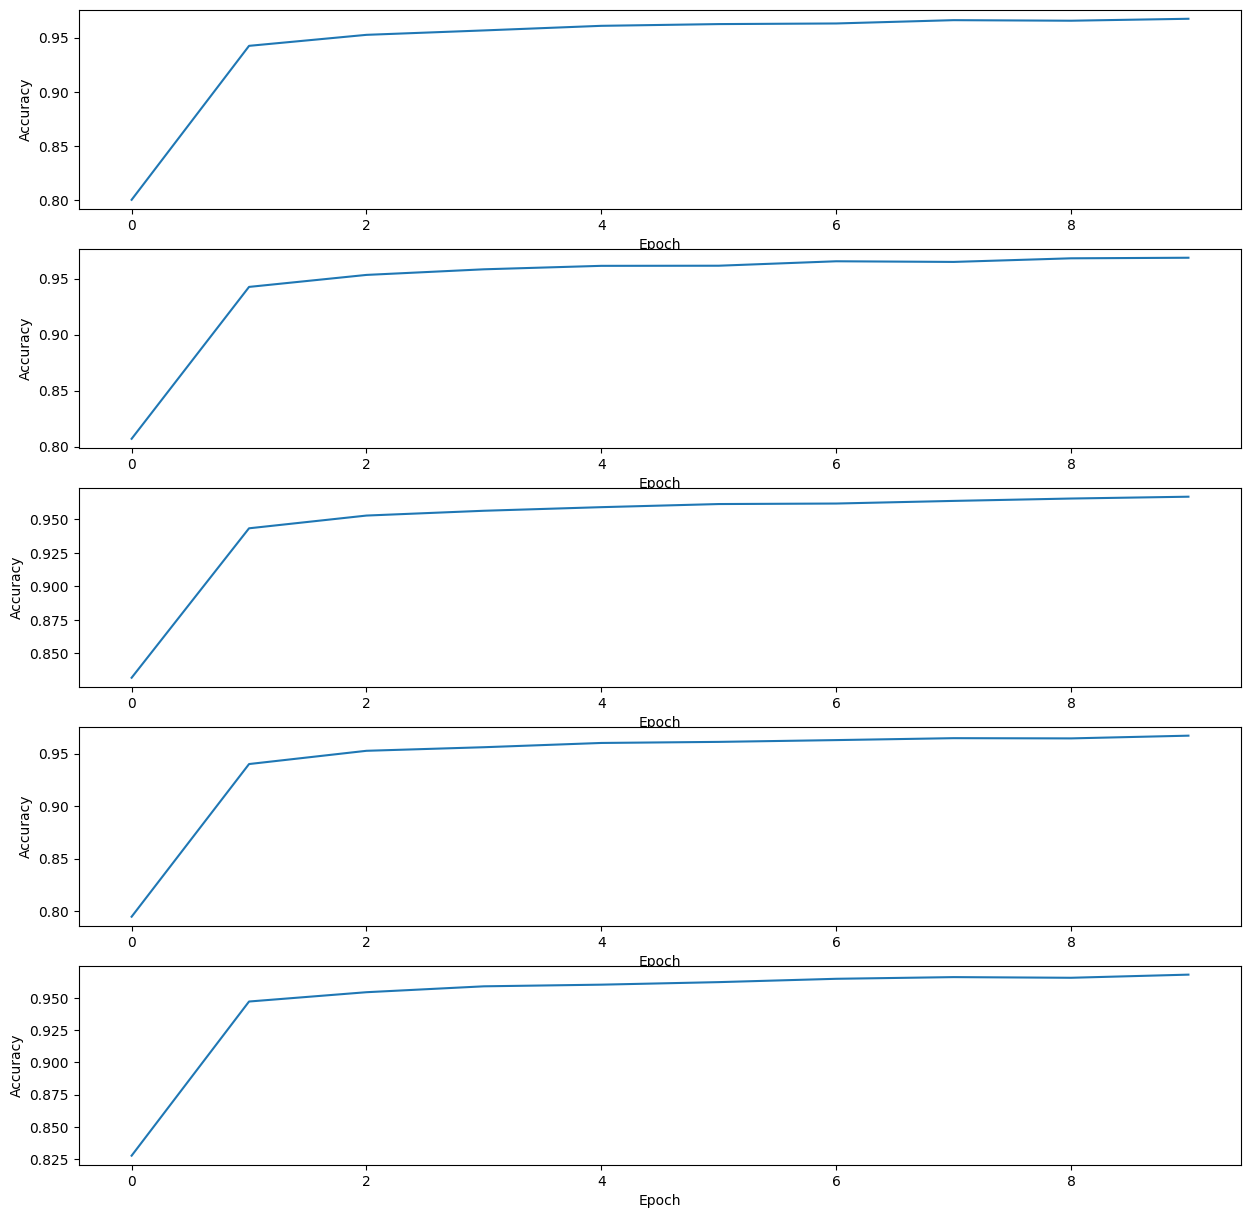

In [12]:
batch_size = 100
epochs = 10

accuracy_list = []
loss_list = []

nb_folds = 5
kfold = StratifiedKFold(n_splits=nb_folds, shuffle=True, random_state=42)

plt.figure(figsize=(15,15))
for i, (train, test) in enumerate(kfold.split(X,Y)):
    print(f"Fold-{i+1}")
    model = create_model()
    model.compile(optimizer="adam",
             loss= "sparse_categorical_crossentropy",
             metrics=["accuracy"])
    history = model.fit(X[train],Y[train],
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1)
    plt.subplot(5,1,i+1)
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    test_loss, test_acc = model.evaluate(X[test], Y[test], verbose=1)
    accuracy_list.append(test_acc)
    loss_list.append(test_loss)
plt.show()


In [13]:
for i in range(nb_folds):
    print("Fold-{} : accuracy = {:.3f} | loss = {:.3f}".format(i+1, accuracy_list[i], loss_list[i]))

Fold-1 : accuracy = 0.965 | loss = 0.097
Fold-2 : accuracy = 0.963 | loss = 0.102
Fold-3 : accuracy = 0.967 | loss = 0.095
Fold-4 : accuracy = 0.963 | loss = 0.104
Fold-5 : accuracy = 0.967 | loss = 0.098


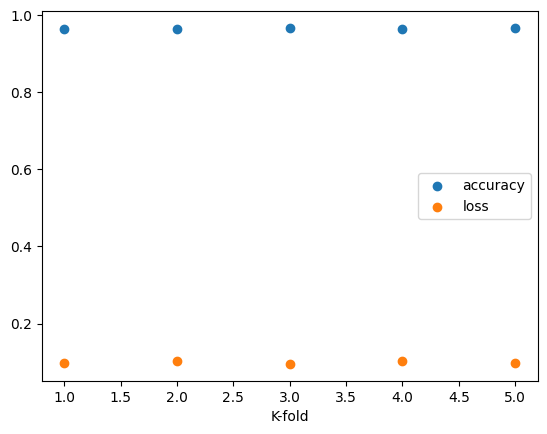

In [16]:
plt.scatter(np.arange(1,nb_folds+1),accuracy_list, label="accuracy")
plt.scatter(np.arange(1,nb_folds+1),loss_list, label="loss")
plt.xlabel("K-fold")
plt.legend()
plt.show()

### Final model

In [ ]:
model = create_model()

model.compile(optimizer="adam",
             loss= "sparse_categorical_crossentropy",
             metrics=["accuracy"])

batch_size = 10
epochs = 10

history = model.fit(X,Y,
                    batch_size=batch_size,
                    epochs=epochs,La première architecture de notre modèle était assez simple. Elle est constituée de trois couches de convolution munies d'un noyau de taille 3x3. La taille du noyau est la plus petite possible afin de prendre en compte les petits patterns. Après chaque couche de convolution, il y a une couche de "pooling" et une couche de "dropout". La couche de dropout sert à éviter le surapprentissage en désactivant temporairement certains neurones du réseau de sorte à ce d'autres puissent être actifs.La première architecture de notre modèle était assez simple. Elle est constituée de trois couches de convolution munies d'un noyau de taille 3x3. La taille du noyau est la plus petite possible afin de prendre en compte les petits patterns. Après chaque couche de convolution, il y a une couche de "pooling" et une couche de "dropout". La couche de dropout sert à éviter le surapprentissage en désactivant temporairement certains neurones du réseau de sorte à ce d'autres puissent être actifs.
                    verbose=1)

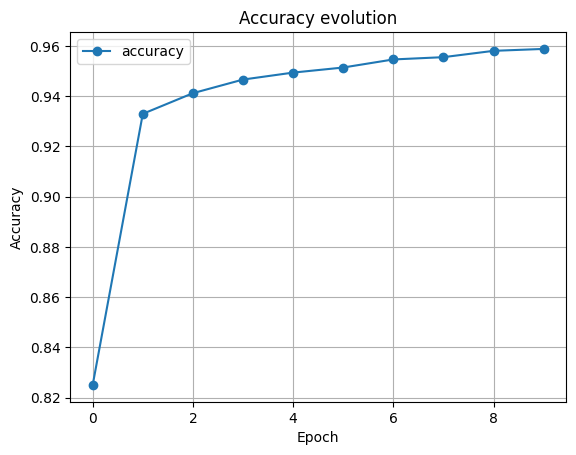

In [13]:
plt.plot(history.history["accuracy"], label="accuracy",marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy evolution")
plt.grid()
plt.legend()
plt.show()

### Saving the model

In [14]:
model_path = "./models/"
model.save(model_path+f"gender_clf_mix_utk_12000.keras",overwrite=True)